**Plan General para el Análisis del Dataset `ISCRAM_maria_tweets.csv`**

---

### 🔍 **1. Adaptación del Esquema de Análisis Propuesto**
- **Objetivo Principal:** Realizar un análisis multidimensional de tweets relacionados con el huracán María, integrando datos crudos, metadatos y técnicas avanzadas de NLP.
- **Diferencias Clave vs. el Ejemplo:**  
  - El dataset original incluye **métricas de engagement** (`like_count`, `retweet_count`), **fechas** (`created_at`) y **idiomas** (`lang`), lo que permite enriquecer el análisis con dimensiones temporales y sociales.  
  - No hay columnas predefinidas de `Label` o `Split`, por lo que se requerirá **crear categorías semánticas** basadas en contenido/texto.

---

### 📊 **2. Etapas Clave del Análisis**

#### **A. Preprocesamiento y Limpieza**  
- **Renombrar columnas** para claridad (ej: `id` → `tweet_id`, `text` → `tweet_text`).  
- **Limpieza textual:**  
  - Eliminar URLs, menciones (@), hashtags (#), caracteres especiales.  
  - Normalización (minúsculas, manejo de emojis/errores ortográficos).  
  - Detección de idioma (`lang`) para segmentar análisis por lenguaje (español/inglés).  
- **Crear columna `Clean_Text`** estandarizada.  

#### **B. Ingeniería de Features**  
- **Features básicos:**  
  - `Tweet_Length`: Longitud del texto.  
  - `Is_RT`: Identificación de retweets (si comienza con "RT").  
  - `Exclamation_Count`: Número de signos de exclamación.  
  - `Engagement_Score`: Combinación de `like_count` + `retweet_count`.  
- **Features semánticas:**  
  - **Detección de temas clave:**  
    - *Ayuda humanitaria* (`help`, `food`, `water`, `donate`).  
    - *Daños* (`destroyed`, `power outage`, `flood`).  
    - *Críticas/Política* (`Trump`, `government`, `FEMA`).  
  - **Extracción de entidades nombradas** (lugares, organizaciones).  

#### **C. Análisis Temporal**  
- **Series de tiempo:** Frecuencia de tweets por hora/día.  
- **Correlación** entre eventos climáticos (ej: impacto de María el 20/09/2017) y actividad en redes.  
- **Engagement por fase del desastre:** Comparar métricas antes/durante/después del huracán.  

#### **D. Análisis de Sentimiento y Emociones**  
- **Modelos multilingües** (ej: VADER para inglés, NLP en español para tweets en ese idioma).  
- **Clasificación emocional:**  
  - `Urgencia` (uso de exclamaciones, palabras clave).  
  - `Crítica` (mención a instituciones/figuras políticas).  
  - `Solidaridad` (llamados a donaciones/voluntariado).  

#### **E. Redes Sociales y Influencia**  
- **Análisis de usuarios:**  
  - Top usuarios por `retweet_count` (posibles influenciadores).  
  - Distribución geográfica basada en perfiles (`username`).  
- **Propagación de información:** Mapear redes de retweets para identificar nodos centrales.  

#### **F. Visualizaciones**  
- **Mapas de calor temporales** de actividad/engagement.  
- **Word Clouds** por categoría semántica (ej: ayuda vs. críticas).  
- **Gráficos de barras** para frecuencia de palabras clave vs. engagement.  
- **Clusterización** (t-SNE/UMAP) coloreada por sentimiento o tema.  

#### **G. Integración con Datos Externos**  
- **Enriquecer con datos oficiales:**  
  - Trayectoria del huracán (NOAA).  
  - Estadísticas de daños (FEMA, gobiernos locales).  
- **Cross-validación:** Comparar menciones en redes con reportes oficiales (ej: cortes de energía).  

---

### 🛠 **3. Herramientas Propuestas**  
- **Limpieza/Preprocesamiento:** `pandas`, `regex`, `langdetect`.  
- **NLP/Features:** `spaCy` (entidades), `nltk` (stopwords), `TextBlob` (sentimiento en español).  
- **Visualizaciones:** `matplotlib`, `seaborn`, `Plotly`, `WordCloud`.  
- **Análisis Temporal:** `statsmodels`, `prophet`.  
- **Redes:** `networkx`, `Gephi`.  

---

### ✅ **4. Entregables Esperados**  
1. **Dataset enriquecido** con features semánticas, temporalidad y sentimiento.  
2. **Reporte visual** interactivo (ej: Jupyter Notebook o Dash).  
3. **Insights accionables:**  
   - Patrones de comunicación durante crisis.  
   - Efectividad de mensajes clave (ej: tweets con alto engagement).  
   - Identificación de desinformación o brechas en la ayuda.  

---

Este plan busca no solo replicar la estructura del ejemplo, sino **ampliarla** con dimensiones únicas del dataset (metadatos de engagement, temporalidad, multilingüismo). ¿Necesitas ajustar algún componente?

Citations:
[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/59985647/9edd51ea-519c-4c58-90ad-430e0db5e5fa/ISCRAM_maria_tweets.csv


✅ Preprocesamiento completado y gráficos generados.


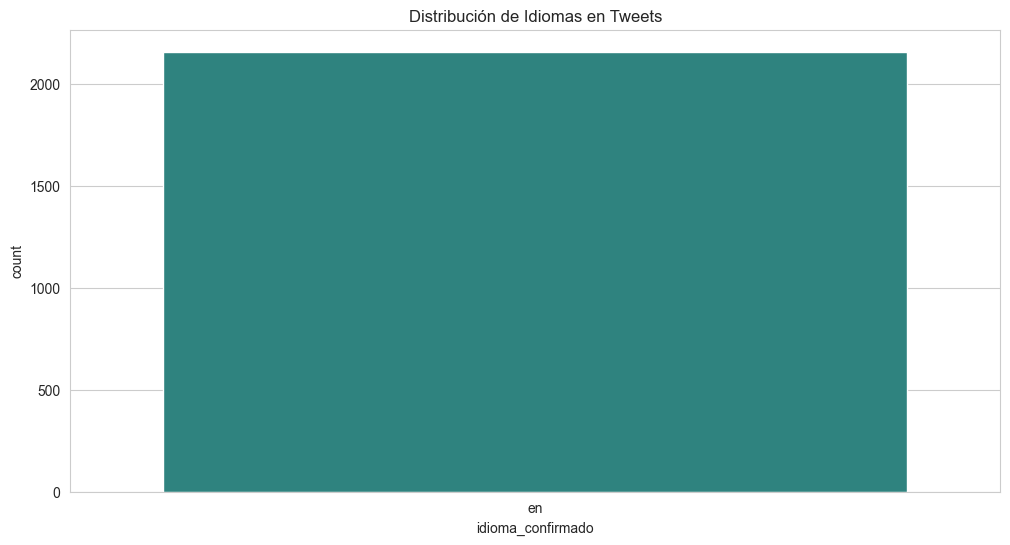

In [2]:
import pandas as pd
import re
import emoji
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df = pd.read_csv('ISCRAM_maria_tweets.csv')

# Renombrar columnas y eliminar duplicados
df = df.rename(columns={
    'id': 'tweet_id',
    'text': 'tweet_text',
    'created_at': 'fecha_creacion',
    'like_count': 'num_likes',
    'retweet_count': 'num_retweets',
    'lang': 'idioma_original',
    'username': 'usuario'
}).drop_duplicates(subset='tweet_id')

# Limpieza avanzada del texto
def limpiar_texto(texto):
    if pd.isna(texto):
        return ""
    
    texto = re.sub(r'http\S+|www\S+|@\w+|#(\w+)', lambda m: m.group(1) if m.group(1) else '', texto)
    texto = emoji.demojize(texto, delimiters=(' ', ' '))
    texto = re.sub(r'[^\w\s]|[\d_]', ' ', texto.lower())
    return re.sub(r'\s+', ' ', texto).strip()

df['texto_limpio'] = df['tweet_text'].astype(str).apply(limpiar_texto)

# Detección robusta de idioma
def detectar_idioma(texto):
    try:
        return detect(texto) if len(texto) > 10 else 'unknown'
    except:
        return 'unknown'

df['idioma_confirmado'] = df['texto_limpio'].apply(detectar_idioma)

# Procesamiento de fechas con formato específico
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

# Filtrar tweets en inglés para análisis posterior
df = df[df['idioma_confirmado'] == 'en']

# Ingeniería de características adicionales
df['longitud_texto'] = df['texto_limpio'].apply(len)
df['es_retweet'] = df['tweet_text'].str.startswith('RT').astype(int)
df['num_hashtags'] = df['tweet_text'].str.count(r'#\w+')
df['num_exclamaciones'] = df['tweet_text'].str.count(r'!')

# Palabras clave relacionadas con ayuda humanitaria (solo inglés)
keywords_ayuda_en = ['help', 'food', 'water', 'rescue', 'donation']
df['contiene_ayuda'] = df['texto_limpio'].apply(
    lambda x: 1 if any(word in x for word in keywords_ayuda_en) else 0
)

# Guardar dataset procesado
df.to_csv('maria_tweets_procesado.csv', index=False)

# Visualización de distribución de idiomas actualizada
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='idioma_confirmado', hue='idioma_confirmado', palette='viridis', legend=False)
plt.title('Distribución de Idiomas en Tweets')
plt.savefig('distribucion_idiomas_actualizada.png', bbox_inches='tight')

print("✅ Preprocesamiento completado y gráficos generados.")
